In [632]:
# Import Libraries
# =========================================================

## BUILT-IN IMPORTS
import warnings
from itertools import combinations
from collections import Counter, defaultdict

## DATA MANIPULATION IMPORTS
import numpy as np
import pandas as pd

## VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

## SKLEARN
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

## XGBOOST
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier

## SHAP
import shap

## GLOBAL SETTINGS
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.max_rows", 500)
plt.rcParams["savefig.bbox"] = "tight"

In [633]:
def missing_summary(df):
    has_non = 0
    for column in df.columns:
        total_values = len(df)
        missing_values = df[column].isnull().sum()
        percentage = ((missing_values/total_values)*100).round(2)
        if missing_values > 0:
            print('df["{}"] - Total values: {}, Missing values: {} ({}%)'.format(column, total_values, missing_values, percentage,))
        else:
            has_non += 1
    if has_non == len(df.columns):
        print("Provided dataframe does not have any missing values.")
        
#############################################################
## my 5 minutes of extreme sillyness
def print_formatted_word(word):
    total_length = len("####################  SCORES & EVALUATIONS  #############################")
    word_length = len(word)
    num_of_hashes_before = len("####################  ")
    num_of_hashes_after = total_length - (num_of_hashes_before + word_length)
    print("#" * num_of_hashes_before + " " + word + " " + "#" * num_of_hashes_after)

#############################################################



In [634]:
df = pd.read_csv("../data/Bobs_df_semi_clean.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["pk_cid"] = df["pk_cid"].astype(str)

In [635]:
missing_summary(df)

df["salary"] - Total values: 5962924, Missing values: 1512103 (25.36%)
df["salary_LN"] - Total values: 5962924, Missing values: 1512103 (25.36%)


In [636]:
df.rename(columns = {
    "payroll": "payroll_product", 
    "payroll_account": "payroll_bonus",
    "active_customer": "active_on_app"}, inplace = True)

In [637]:
product_revenue_map = {"short_term_deposit": 60, "loans": 40, "mortgage": 40, "funds": 60, "securities": 60, "long_term_deposit": 60, "credit_card": 40, "pension_plan": 60, "payroll_product": 10, "emc_account": 10, "debit_card": 40, "em_account_p": 10, "em_acount": 10}

products = list(product_revenue_map.keys())

In [638]:
## removing deceased customers and respective feature
df = df[df["deceased"] == 0]
df.drop("deceased", axis = 1, inplace = True)

## we will focus on customers registed and resident in Spain (ES)
df = df[df["country_id"] == "ES"]
df.drop("country_id", axis = 1, inplace = True)

## ultimately we will only be looking at users who have been active in the last 3 months, so we can drop all users who are users for less than 3 months
#df = df[df["entry_date"] <= "2019-03-01"]

## dropping entry date as we're only interested in users who have been active recently and we only have data for the past 17 months. What happened before we do not know.
#df.drop("entry_date", axis = 1, inplace = True)

## also dropping "segment" and "gender" features for trust and ethics reasons
df.drop(["Male", "segment"], axis = 1, inplace = True)

## and dropping "salary" features, as we have too many missing values and values do not seem realistic (way above any reasonable salary)
df.drop(["salary", "salary_LN"], axis = 1, inplace = True)

## finally dropping "active_customer" feature as we're only looking into users with active products. We assume that all users with active prodcuts are active customers.
#df.drop("active_customer", axis = 1, inplace = True)

df.shape

(5959602, 22)

In [639]:
## creating revenue features
#df_product = df[products]
#revenues = np.array([product_revenue_map[f] for f in products])
#df["total_revenue"] = (df_product * revenues).sum(axis = 1)
#df_user_revenue = df.groupby("pk_cid")["total_revenue"].sum().reset_index()
#df = pd.merge(df, df_user_revenue, on = "pk_cid", how = "left")

#df.rename(columns = {"total_revenue_x": "revenue_month", "total_revenue_y": "revenue_total"}, inplace = True)

In [640]:
## adding revenue class feature
#revenue_classes_dict = {
#    "None": (-1, 0),
#    "Micro": (1, 50),
#    "Low": (51, 170),    
#    "mid": (171, 849),
#    "upper": (850, 1200),
#    "high": (1201, 10000)}

#df["revenue_class"] = df["revenue_total"].apply(
#    lambda x: next((cat for cat, range in revenue_classes_dict.items() if range[0] <= x #<= range[1])))

In [641]:
# removing customers with zero revenue as we cannot make conclusions about purchase and tenure behavior
#print(df.shape)
#df = df[df["revenue_class"] != "None"]
df.shape

(5959602, 22)

In [630]:
df["pk_cid"].nunique()

456172

In [646]:
products

['short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'pension_plan',
 'payroll_product',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [645]:
df

,pk_cid,pk_partition,age,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll_product,pension_plan,payroll_bonus,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,active_on_app,region
0,1375586,2018-01-28,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-12,KHL,1,Malaga
1,1050611,2018-01-28,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,KHE,0,Ciudad Real
2,1050612,2018-01-28,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,KHE,0,Ciudad Real
3,1050613,2018-01-28,22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015-08-10,KHD,0,Zaragoza
4,1050614,2018-01-28,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,KHE,1,Zaragoza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,KHE,0,Zaragoza
5962920,1166764,2019-05-28,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,KHE,0,La Rioja
5962921,1166763,2019-05-28,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,KHE,1,Zaragoza
5962922,1166789,2019-05-28,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,KHE,0,Zaragoza


In [713]:
def stringify_df(data, TARGET):

    to_stringify = ["em_acount", "em_account_p", "emc_account", "short_term_deposit", "long_term_deposit", "loans", "mortgage", "funds", "securities", "debit_card", "credit_card", "pension_plan", "payroll_product", "payroll_bonus", "active_on_app"]
 
    string_DF = pd.DataFrame(index = data["pk_cid"].unique())

    # adding age
    age = data.groupby("pk_cid")["age"].max()
    string_DF = pd.concat([string_DF, age], axis = 1)

    # stringify features
    for feature in to_stringify: 
        data[feature] = data[feature].astype(str)
        temp_SERIES = data.groupby("pk_cid")[feature].sum()
        string_DF = pd.concat([string_DF, temp_SERIES], axis = 1)
    
    # removing customers with less than 3 months of recordings
    string_DF = string_DF[string_DF[TARGET].apply(len) >= 3]
    
    return string_DF

In [683]:
TARGET = "securities"

activity_products = ["debit_card", "credit_card", "payroll_product", "pension_plan"]
plan_products = ["emc_account", "em_account_p", "em_acount", "short_term_deposit", "long_term_deposit", "securities", "funds", "mortage", "loans"]

stringed_DF = stringify_df(df, TARGET)
stringed_DF

,age,em_acount,em_account_p,emc_account,short_term_deposit,long_term_deposit,loans,mortgage,funds,securities,debit_card,credit_card,pension_plan,payroll_product,payroll_bonus,active_on_app
1375586,36,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00001110000000001,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111110000000101
1050611,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000
1050612,23,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000
1050613,23,00000000000000,00000000000000,00000000000000,11000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000
1050614,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014354,38,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000
1014312,51,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000
1082677,28,011,000,000,000,000,000,000,000,000,011,000,000,000,000,011
1035063,33,011,000,000,000,000,000,000,000,000,001,000,000,000,000,001


In [723]:
df[df["pk_cid"] == "1014354"]

,pk_cid,pk_partition,age,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll_product,pension_plan,payroll_bonus,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,active_on_app,region
5021283,1014354,2019-03-28,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-03-21,KFC,0,Madrid
5260477,1014354,2019-04-28,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-03-21,KFC,0,Madrid
5834659,1014354,2019-05-28,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-03-21,KFC,0,Madrid


In [715]:
stringed_DF.drop("other_active_products", axis = 1, inplace = True)

In [717]:
test = stringed_DF.copy(deep = True)

In [722]:
test["em_acount"].str.split("", expand = True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1375586,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1050611,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1050612,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1050613,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,None,None,None
1050614,,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014354,,0,0,0,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1014312,,0,0,0,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1082677,,0,1,1,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1035063,,0,1,1,,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [719]:
test

,age,em_acount,em_account_p,emc_account,short_term_deposit,long_term_deposit,loans,mortgage,funds,securities,debit_card,credit_card,pension_plan,payroll_product,payroll_bonus,active_on_app
1375586,36,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00001110000000001,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111110000000101
1050611,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000
1050612,23,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000
1050613,23,00000000000000,00000000000000,00000000000000,11000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000
1050614,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014354,38,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000
1014312,51,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000
1082677,28,011,000,000,000,000,000,000,000,000,011,000,000,000,000,011
1035063,33,011,000,000,000,000,000,000,000,000,001,000,000,000,000,001


In [587]:
## TARGET CANNOT BE any activity_product
## first, create timeline string
## identify target last activation
## coocurrence for month BEFORE last activation
## slice target string to 1 month BEFORE last activation
## add average monthly revenue on all users
## product retention (maybe including target!)
## product frequency (maybe including target!)
## product retention / length of recording (maybe including target!)

In [684]:
def get_other_active_products(row, products, TARGET):
    product_string_index = row.index.get_loc(TARGET)
    product_string_activation_index = row[product_string_index].rfind("01") if "01" in row[product_string_index] else None

    #row[product_string_index] = row[product_string_index].split("01")[0]

    other_active_products = []
    if product_string_activation_index is not None:
        for i, column in enumerate(row.index):
            if i != product_string_index and column in products:
                if row[column][product_string_activation_index] == "1":
                    other_active_products.append(column)
    else:
        other_active_products.append(None)
    
    return other_active_products

stringed_DF["other_active_products"] = stringed_DF.apply(get_other_active_products, args = (products, TARGET), axis = 1)

stringed_DF

,age,em_acount,em_account_p,emc_account,short_term_deposit,long_term_deposit,loans,mortgage,funds,securities,debit_card,credit_card,pension_plan,payroll_product,payroll_bonus,active_on_app,other_active_products
1375586,36,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00001110000000001,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111110000000101,[None]
1050611,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,[None]
1050612,23,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,[None]
1050613,23,00000000000000,00000000000000,00000000000000,11000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,[None]
1050614,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111,[None]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014354,38,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,[None]
1014312,51,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,[None]
1082677,28,011,000,000,000,000,000,000,000,000,011,000,000,000,000,011,[None]
1035063,33,011,000,000,000,000,000,000,000,000,001,000,000,000,000,001,[None]


In [667]:
df["payroll_bonus"].value_counts()

0    5630358
1     329244
Name: payroll_bonus, dtype: int64

In [652]:
activity_products = ["debit_card", "credit_card", "payroll_product", "pension_plan"]
plan_products = ["emc_account", "em_account_p", "em_acount", "short_term_deposit", "long_term_deposit", "securities", "funds", "mortage", "loans"]

In [669]:
stringed_DF[stringed_DF["other_active_products"] != "None"].head(50)

,age,em_acount,em_account_p,emc_account,short_term_deposit,long_term_deposit,loans,mortgage,funds,securities,debit_card,credit_card,pension_plan,payroll_product,payroll_bonus,active_on_app,other_active_products
1375586,36,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00001110000000001,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111110000000101,[None]
1050611,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,[None]
1050612,23,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,[None]
1050613,23,00000000000000,00000000000000,00000000000000,11000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,00000000000000,[None]
1050614,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111,[None]
1050615,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,[None]
1050616,24,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,[None]
1050617,23,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111,[None]
1050619,25,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,[None]
1050620,24,11111111111111100,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,[None]


In [685]:
stringed_DF["other_active_products"] = stringed_DF["other_active_products"].astype(str)
stringed_DF["other_active_products"] = stringed_DF["other_active_products"].str.strip('[]').str.replace("'", "").str.replace(" ", "")

stringed_DF_ = stringed_DF["other_active_products"].str.split(",", expand = True)

stringed_DF_.reset_index(inplace = True)

cooc_pre = stringed_DF_.melt(id_vars = "index")
cooc_pre["value"].fillna("Unknown", inplace = True)
cooc_pre.rename(columns = {"index" :"pk_cid"}, inplace = True)

cooc_pre = cooc_pre.pivot_table(index = "pk_cid", columns = "value", aggfunc = len, fill_value = 0)
new_columns = [tupple[1] for tupple in list(cooc_pre.columns)]
cooc_pre.columns = new_columns
cooc_pre.reset_index(inplace = True)
cooc_pre.head()

cooc_pre.drop(["", "None", "Unknown"], axis = 1, inplace = True)
cooc_pre.set_index("pk_cid", inplace = True)

In [686]:
cooc_pre

,credit_card,debit_card,em_acount,emc_account,funds,long_term_deposit,payroll_product,pension_plan,short_term_deposit
pk_cid,,,,,,,,,
1000028,0,0,0,0,0,0,0,0,0
1000096,0,0,0,0,0,0,0,0,0
1000105,0,0,0,0,0,0,0,0,0
1000113,0,0,0,0,0,0,0,0,0
1000130,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
998859,0,0,0,0,0,0,0,0,0
999706,0,0,0,0,0,0,0,0,0
999825,0,0,0,0,0,0,0,0,0


In [700]:
cooc_pre["TARGET"] = stringed_DF[TARGET].apply(lambda x: 1 if "01" in x else 0)
final_DF = cooc_pre.copy()

In [690]:
print(TARGET)
cooc_pre["TARGET"].value_counts()

securities


0    440206
1      1168
Name: TARGET, dtype: int64

In [567]:
# retention per product (total number of active months)
# retention / activity time per product (total number of active months / total number of months)
# recency per product (months past since latest activation)

stringed_DF["TARGET"] = stringed_DF[TARGET].apply(lambda x: 1 if "01" in x else 0)
stringed_DF["active_months"] = stringed_DF["loans"].apply(lambda s: len(s))

for product in [p for p in products if p != TARGET]:

    tenure_ = stringed_DF[product].apply(
        lambda s: sum([int(i) for i in s]))
    stringed_DF[product + "_tenure_rate"] = tenure_ / len(df[product][0])
    
    stringed_DF[product + "_last_act"] = stringed_DF[product].apply(
        lambda s: 
            -1 if "1" in s and s.rfind("01") == -1 
            else len(s) - s.rfind("01") - 2 if s.rfind("01") != -1 
            else 999999)

stringed_DF.drop(products, axis = 1, inplace = True)
stringed_DF.drop("other_active_products", axis = 1, inplace = True)

In [ ]:
print(cooc_pre.shape)
print(stringed_DF.shape)
final_DF = pd.concat([stringed_DF["TARGET"], cooc_pre], axis = 1)
print(final_DF.shape)
final_DF

In [696]:
final_DF["TARGET"].value_counts()

0    440206
1      1168
Name: TARGET, dtype: int64

In [697]:
TARGET

'securities'

In [698]:
final_DF.corr().style.background_gradient(axis = None)

,credit_card,debit_card,em_acount,emc_account,funds,long_term_deposit,payroll_product,pension_plan,short_term_deposit,TARGET
credit_card,1.000000,0.362008,0.219201,0.305412,0.121400,0.179823,0.308188,0.342711,0.025607,0.293707
debit_card,0.362008,1.000000,0.563045,0.437653,0.113718,0.238915,0.458376,0.478831,0.084219,0.626377
em_acount,0.219201,0.563045,1.000000,0.396371,0.197946,0.257348,0.200548,0.208773,0.108808,0.901164
emc_account,0.305412,0.437653,0.396371,1.000000,0.215215,0.342810,0.365201,0.379252,0.014540,0.513848
funds,0.121400,0.113718,0.197946,0.215215,1.000000,0.257712,0.110607,0.116233,0.031475,0.239207
long_term_deposit,0.179823,0.238915,0.257348,0.342810,0.257712,1.000000,0.204894,0.220843,-0.000087,0.290783
payroll_product,0.308188,0.458376,0.200548,0.365201,0.110607,0.204894,1.000000,0.969967,0.038928,0.386641
pension_plan,0.342711,0.478831,0.208773,0.379252,0.116233,0.220843,0.969967,1.000000,0.037753,0.398613
short_term_deposit,0.025607,0.084219,0.108808,0.014540,0.031475,-0.000087,0.038928,0.037753,1.000000,0.113176
TARGET,0.293707,0.626377,0.901164,0.513848,0.239207,0.290783,0.386641,0.398613,0.113176,1.000000


In [699]:
corr_matrix = final_DF.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)
final_DF = final_DF.drop(to_drop, axis = 1)

['pension_plan', 'TARGET']


In [701]:
X = final_DF.drop(["TARGET"], axis = 1)
y = final_DF["TARGET"]

balance = (len(final_DF[final_DF["TARGET"] == 1]) / len(final_DF[final_DF["TARGET"] == 0])) * 100

train, test, target, target_test = train_test_split(
    X, y, test_size = 0.3)

split_data_dict = {
    "TRAINING": [train, target],
    "TESTING": [test, target_test]}

print("Train:", train.shape, "| Target Mean:", target.mean())
print("Test:", test.shape, "| Target Mean:", target_test.mean())

Train: (308961, 9) | Target Mean: 0.0026475833519440965
Test: (132413, 9) | Target Mean: 0.002643244998602856


In [704]:
XGB_model = XGBClassifier(
    max_depth = 4,
    random_state = 42,
    learning_rate = 0.002,
    colsample_bylevel = 0.5,
    verbosity = 0,
    scale_pos_weight = balance,
    n_jobs = -1)

XGB_model.fit(train, target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.002, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

###################### securities #########################################

______________________ SCORES & EVALUATIONS _______________________________

###################### TRAINING ###########################################
Accuracy: 0.99982 | Precision: 1.0 | Recall: 0.93032 | F1_Score: 0.9639
TN = 308143 | FN = 57 | TP = 761 | FP = 0
Positive prediction value: 100.0% | Negative prediction value: 99.98%

###################### TESTING ############################################
Accuracy: 0.99987 | Precision: 1.0 | Recall: 0.95143 | F1_Score: 0.97511
TN = 132063 | FN = 17 | TP = 333 | FP = 0
Positive prediction value: 100.0% | Negative prediction value: 99.99%

###################### CROSS-VALIDATION ###################################
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.9679         0.0016         0.9680        0.0032
1          0.9698         0.0019         0.9701        0.0058
2          0.9739         0.0014         0.9739        0.0028

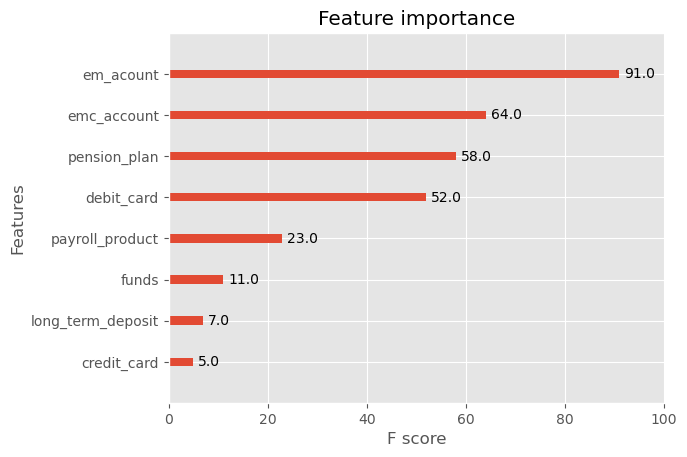

In [705]:
#print_formatted_word("SCORES & EVALUATIONS")
print_formatted_word(TARGET)
print("\n______________________ SCORES & EVALUATIONS _______________________________\n")

for data in split_data_dict.items():

    pred = XGB_model.predict(data[1][0])
    confusion_matrix = metrics.confusion_matrix(data[1][1], pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Accuracy = metrics.accuracy_score(data[1][1], pred)
    Precision = metrics.precision_score(data[1][1], pred)
    Recall = metrics.recall_score(data[1][1], pred)
    F_1_Score = metrics.f1_score(data[1][1], pred)

    probs = XGB_model.predict_proba(data[1][0])[:, 1]
    probs_mean = round(probs.mean()* 100, 2) 
    auc_score = roc_auc_score(data[1][1], probs)
    fpr, tpr, thresholds = roc_curve(data[1][1], probs)

    PPV, NPV = ((tp / (tp + fp)) * 100), ((tn / (fn + tn)) * 100)
    
    
    print_formatted_word(data[0])
    print(f"Accuracy: {round(Accuracy, 5)} | Precision: {round(Precision, 5)} | Recall: {round(Recall, 5)} | F1_Score: {round(F_1_Score, 5)}")
    print(f"TN = {tn} | FN = {fn} | TP = {tp} | FP = {fp}")
    print(f"Positive prediction value: {round(PPV, 2)}% | Negative prediction value: {round(NPV, 2)}%\n")

data_dmatrix = xgb.DMatrix(X, y)
xgb_cv = cv(
    dtrain = data_dmatrix, 
    params = XGB_model.get_params(), 
    nfold = 3,
    num_boost_round = 50, 
    early_stopping_rounds = 10, 
    metrics = "auc", 
    as_pandas = True, 
    seed = 42)

print_formatted_word("CROSS-VALIDATION")
  
print(xgb_cv.head())

xgb.plot_importance(XGB_model)
plt.show()

In [706]:
apply_DF = final_DF[final_DF["TARGET"] == 0]
apply_DF.drop(["TARGET"], axis = 1, inplace = True)
probs_apply = XGB_model.predict_proba(apply_DF)
probs_apply

array([[0.59068805, 0.40931195],
       [0.59068805, 0.40931195],
       [0.59068805, 0.40931195],
       ...,
       [0.59068805, 0.40931195],
       [0.59068805, 0.40931195],
       [0.59068805, 0.40931195]], dtype=float32)

In [707]:
Test_OUT = apply_DF.copy(deep = True)
Test_OUT["probs"] = probs_apply[:, 1]

In [708]:
Test_OUT.sort_values(by = "probs", ascending = False).head(10)

,credit_card,debit_card,em_acount,emc_account,funds,long_term_deposit,payroll_product,pension_plan,short_term_deposit,probs
pk_cid,,,,,,,,,,
1000028,0,0,0,0,0,0,0,0,0,0.4093
1368379,0,0,0,0,0,0,0,0,0,0.4093
1368377,0,0,0,0,0,0,0,0,0,0.4093
1368376,0,0,0,0,0,0,0,0,0,0.4093
1368375,0,0,0,0,0,0,0,0,0,0.4093
1368374,0,0,0,0,0,0,0,0,0,0.4093
1368373,0,0,0,0,0,0,0,0,0,0.4093
1368371,0,0,0,0,0,0,0,0,0,0.4093
1368370,0,0,0,0,0,0,0,0,0,0.4093


In [709]:
pd.Series(probs_apply[:, 1]).sort_values(ascending = True).value_counts().head()

0.4093    440206
dtype: int64

In [710]:
LL = pd.Series(probs_apply[:, 1]).sort_values(ascending = False)

In [711]:
LL[LL > 0.5].count()

0

In [712]:
LL.describe()

count   440,206.0000
mean          0.4076
std           0.0017
min           0.4093
25%           0.4093
50%           0.4093
75%           0.4093
max           0.4093
dtype: float64

In [464]:
apply_DF

,age,active_months,short_term_deposit_tenure_rate,loans_tenure_rate,mortgage_tenure_rate,funds_tenure_rate,securities_tenure_rate,long_term_deposit_tenure_rate,credit_card_tenure_rate,pension_plan_tenure_rate,emc_account_tenure_rate,debit_card_tenure_rate,em_account_p_tenure_rate,em_acount_tenure_rate,em_acount_last_act,credit_card,debit_card,em_account_p,em_acount,emc_account,funds,loans,long_term_deposit,mortgage,securities,short_term_deposit
1375586,36,17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,17.0000,-1,0,0,0,0,0,0,0,0,0,0,0
1050611,24,17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.0000,-1,0,0,0,0,0,0,0,0,0,0,0
1050612,23,17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.0000,-1,0,0,0,0,0,0,0,0,0,0,0
1050613,23,14,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,999999,0,0,0,0,0,0,0,0,0,0,0
1050614,24,17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.0000,-1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017056,34,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,1.0000,0,0,0,0,0,0,0,0,0,0,0,0
1014969,46,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-1,0,0,0,0,0,0,0,0,0,0,0
1082677,28,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,2.0000,1,0,0,0,0,0,0,0,0,0,0,0
1035063,33,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,1,0,0,0,0,0,0,0,0,0,0,0
